In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.cm as cm
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [ ]:
# import cv2

# graytest = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_test])
# testing=[]
# for img in graytest:
#   img=img
#   stacked_img = np.stack((img,)*3, axis=-1)
#   testing.append(stacked_img)
# testing =np.asarray(testing)
# testing.shape
# graytest=testing
# X_test=graytest

In [ ]:
baseModel = tf.keras.applications.VGG16(weights=False, include_top=False,
	input_tensor=Input(shape=(32, 32, 3)))

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(10, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss = loss_object, metrics=['accuracy'])

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
history = model.fit(X_train, y_train, batch_size = 64, epochs = 10, validation_data=(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
782/782 [==============================] - 78s 98ms/step - loss: 3.0628 - accuracy: 0.4157 - val_loss: 1.6148 - val_accuracy: 0.4334
Epoch 2/10
782/782 [==============================] - 76s 97ms/step - loss: 1.4239 - accuracy: 0.5140 - val_loss: 1.5547 - val_accuracy: 0.4583
Epoch 3/10
782/782 [==============================] - 76s 97ms/step - loss: 1.3158 - accuracy: 0.5465 - val_loss: 1.5310 - val_accuracy: 0.4714
Epoch 4/10
782/782 [==============================] - 76s 97ms/step - loss: 1.2660 - accuracy: 0.5650 - val_loss: 1.5179 - val_accuracy: 0.4733
Epoch 5/10
782/782 [==============================] - 75s 96ms/step - loss: 1.2312 - accuracy: 0.5751 - val_loss: 1.4828 - val_accuracy: 0.4898
Epoch 6/10
782/782 [==============================] - 75s 96ms/step - loss: 1.2113 - accuracy: 0.5845 - val_loss: 1.5003 - val_accuracy: 0.4742
Epoch 7/10
782/782 [==============================] - 75s 96ms/step - loss: 1.1906 - accuracy: 0.5940 - val_loss: 1.5031 - val_accuracy:

In [ ]:
y_probgray = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
predgray = list(np.argmax(y_probgray[i]) for i in range(len(y_probgray)))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_test, predgray)

0.6148

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
img_size = (32, 32)

last_conv_layer_name = "block3_conv3"
classifier_layer_names = ['block3_pool', 'block4_conv1', 'block4_conv2',
                          'block4_conv3', 'block4_pool', 'block5_conv1',
                          'block5_conv2', 'block5_conv3', 'block5_pool',
                          'flatten', 'dense_2', 'dropout_1', 'dense_3']

In [ ]:
def get_img_array(img):
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap



In [ ]:
def get_superimposed(img):
  # Prepare image
  img_array = preprocess_input(get_img_array(img))

  # Print what the top predicted class is
  preds = baseModel.predict(img_array)
  # print("Predicted:", decode_predictions(preds, top=1)[0])

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(
      img_array, model, last_conv_layer_name, classifier_layer_names
  )

  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
  return(superimposed_img, heatmap)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


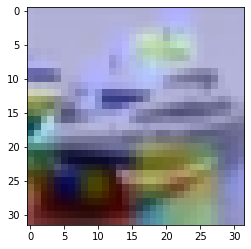

In [ ]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
plt.imshow(get_superimposed(X_test[1])[0])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


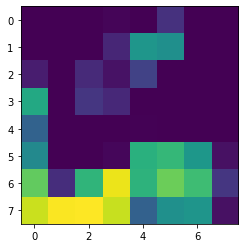

In [ ]:
plt.imshow(get_superimposed(X_test[1])[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


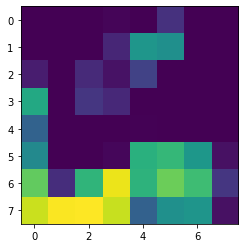

In [ ]:
superimposed_img, heatmap=get_superimposed((X_test[1]))
plt.imshow(heatmap)

list of prediction and test_y

In [ ]:
from array import *
def array_list(array_num):
    num_list = array_num.tolist() # list
    print(num_list)
  
# driver code
array_num = array('i', y_test) # array
array_list(array_num)

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 6, 8, 6, 8, 0, 4, 0, 7, 7, 5, 5, 3, 5, 2, 3, 4, 1, 7, 5, 4, 6, 1, 9, 3, 

In [ ]:
from array import *
def array_list(array_num):
    num_list = array_num.tolist() # list
    print(num_list)
  
# driver code
array_num = array('i', predgray) # array

array_list(array_num)

[3, 8, 8, 0, 6, 6, 3, 6, 3, 5, 0, 9, 4, 5, 9, 6, 3, 7, 8, 6, 5, 0, 3, 9, 4, 2, 7, 9, 9, 6, 6, 5, 4, 3, 9, 3, 7, 1, 9, 5, 7, 6, 7, 3, 0, 9, 3, 1, 7, 2, 0, 8, 7, 3, 8, 8, 7, 2, 4, 3, 7, 3, 6, 3, 6, 6, 1, 2, 3, 9, 2, 6, 8, 8, 0, 2, 0, 6, 5, 7, 8, 1, 1, 7, 2, 7, 2, 3, 8, 9, 0, 6, 5, 2, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 2, 6, 1, 7, 2, 0, 6, 5, 1, 3, 0, 1, 5, 5, 8, 7, 1, 2, 8, 2, 8, 3, 6, 0, 6, 1, 8, 9, 6, 9, 9, 7, 2, 8, 6, 5, 6, 3, 8, 3, 6, 5, 5, 7, 0, 9, 6, 9, 0, 3, 5, 1, 3, 4, 2, 1, 5, 6, 1, 4, 8, 4, 5, 0, 9, 9, 4, 8, 8, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 2, 0, 2, 7, 0, 9, 6, 2, 8, 8, 7, 8, 5, 8, 8, 7, 1, 5, 0, 2, 7, 9, 2, 8, 0, 9, 8, 0, 7, 9, 8, 4, 7, 5, 9, 4, 3, 1, 9, 3, 5, 4, 3, 9, 3, 8, 8, 0, 4, 9, 5, 3, 1, 1, 1, 9, 0, 3, 8, 9, 2, 0, 5, 3, 9, 1, 2, 8, 6, 0, 8, 9, 8, 1, 3, 3, 0, 8, 0, 4, 7, 0, 2, 5, 6, 3, 8, 3, 0, 2, 4, 4, 9, 1, 6, 1, 0, 9, 1, 8, 0, 1, 1, 2, 6, 9, 5, 2, 6, 0, 0, 6, 6, 6, 5, 2, 2, 0, 9, 7, 9, 4, 8, 6, 8, 0, 4, 0, 4, 9, 5, 3, 2, 3, 5, 3, 7, 9, 9, 5, 2, 6, 1, 1, 3, 

Incorrect labels finding

In [ ]:
def find_incorrect_labels(classlabel):
  incrct = []
  count=0
  for i in range(len(X_test)):
    if count==2:
      break
    if (y_test[i] != predgray[i]) and y_test[i]==classlabel:
      incrct.append(i)
      count+=1
  return incrct

In [ ]:
def plot(k):
    i,j=find_incorrect_labels(k)
    f = plt.figure()
    f.add_subplot(2,3, 1)
    plt.imshow(X_test[i])
    plt.title(labels[k])
    plt.axis('off')
    f.add_subplot(2,3, 2)
    superimposed_img, heatmap=get_superimposed((X_test[i]))
    plt.imshow(heatmap)
    plt.axis('off')
    f.add_subplot(2,3, 3)
    pred=predgray[i]
    plt.title(labels[pred])
    plt.imshow(superimposed_img)
    plt.axis('off')
    f.add_subplot(2,3, 4)
    plt.imshow(X_test[j])
    plt.title(labels[k])
    plt.axis('off')
    f.add_subplot(2,3, 5)
    superimposed_img, heatmap=get_superimposed((X_test[j]))
    plt.imshow(heatmap)
    plt.axis('off')
    f.add_subplot(2,3, 6)
    pred=predgray[j]
    plt.title(labels[pred])
    plt.imshow(superimposed_img)
    plt.axis('off')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


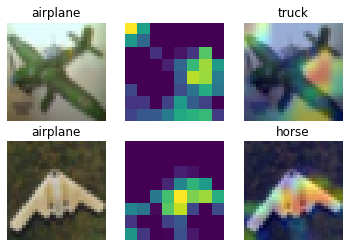

In [ ]:
plot(0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


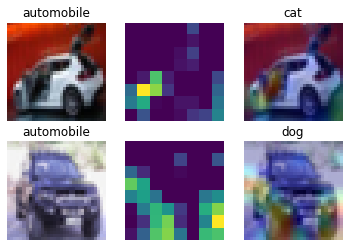

In [ ]:
plot(1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


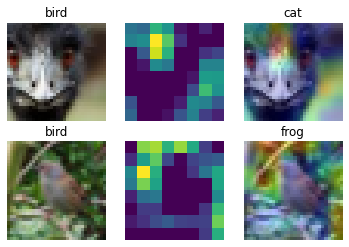

In [ ]:
plot(2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


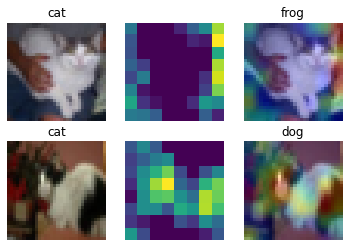

In [ ]:
plot(3)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


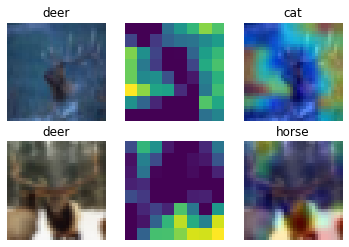

In [ ]:
plot(4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


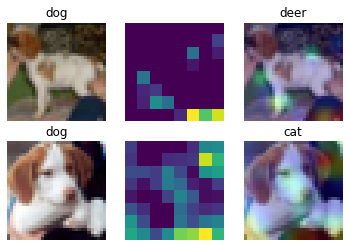

In [ ]:
plot(5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


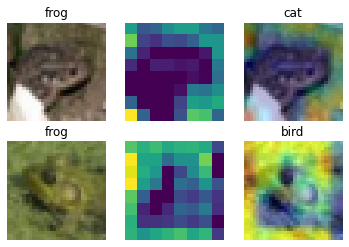

In [ ]:
plot(6)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


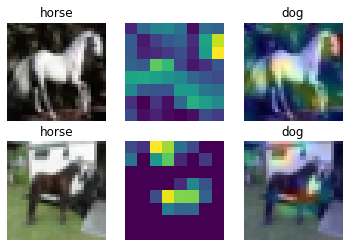

In [ ]:
plot(7)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


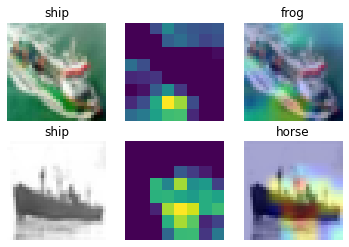

In [ ]:
plot(8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


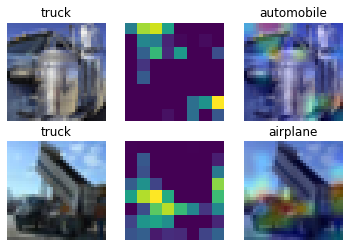

In [ ]:
plot(9)

Correctly classified

In [ ]:
def find_correct_labels(classlabel):
  crct = []
  count=0
  for i in range(len(X_test)):
    if count==2:
      break
    if (y_test[i] == predgray[i]) and y_test[i]==classlabel:
      crct.append(i)
      count+=1
  return crct

In [ ]:
def plot(k):
    i,j=find_correct_labels(k)
    f = plt.figure()
    f.add_subplot(2,3, 1)
    plt.imshow(X_test[i])
    plt.title(labels[k])
    plt.axis('off')
    f.add_subplot(2,3, 2)
    superimposed_img, heatmap=get_superimposed((X_test[i]))
    plt.imshow(heatmap)
    plt.axis('off')
    f.add_subplot(2,3, 3)
    pred=predgray[i]
    plt.title(labels[pred])
    plt.imshow(superimposed_img)
    plt.axis('off')
    f.add_subplot(2,3, 4)
    plt.imshow(X_test[j])
    plt.title(labels[k])
    plt.axis('off')
    f.add_subplot(2,3, 5)
    superimposed_img, heatmap=get_superimposed((X_test[j]))
    plt.imshow(heatmap)
    plt.axis('off')
    f.add_subplot(2,3, 6)
    pred=predgray[j]
    plt.title(labels[pred])
    plt.imshow(superimposed_img)
    plt.axis('off')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


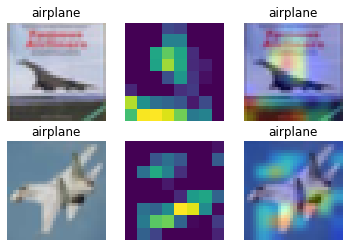

In [ ]:
plot(0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


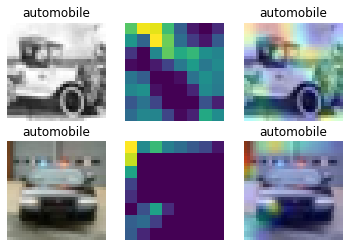

In [ ]:
plot(1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


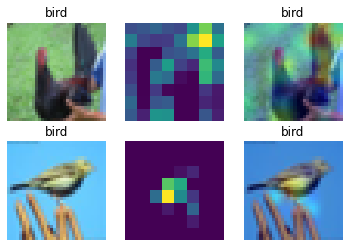

In [ ]:
plot(2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


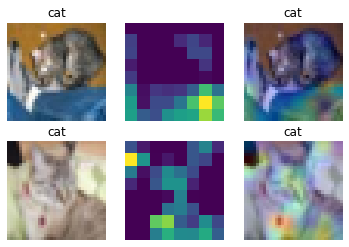

In [ ]:
plot(3)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


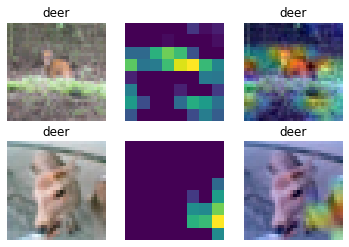

In [ ]:
plot(4)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


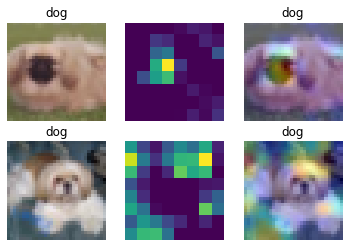

In [ ]:
plot(5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


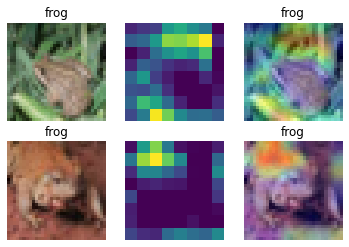

In [ ]:
plot(6)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


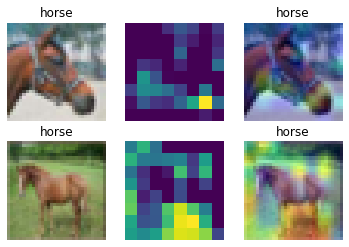

In [ ]:
plot(7)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


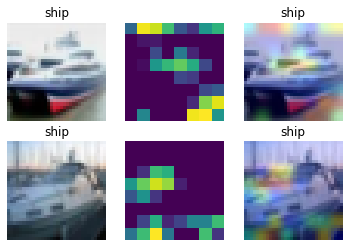

In [ ]:
plot(8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


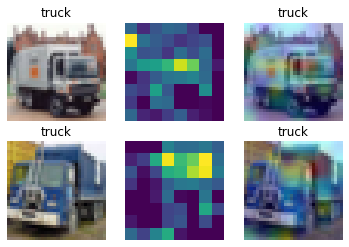

In [ ]:
plot(9)